# PCA and DBSCAN codealong

---

In this detailed codealong/lab we are going to practice and look more extensively at PCA (primarily). If time permits, we will also look at a popular unsupervized learning clustering algorithm called "Density Based Clustering of Applications with Noise" (DBSCAN).

PCA is one of the more difficult concepts/algorithms in this class to understand well in such a short amount of time, but considering how often people use it to simplify their data, reduce noise in their data, and find unmeasured "latent variables", it is important to spend the time to understand what's going on.

Hopefully this will help with that!

---

### How does DBSCAN work?

DBSCAN, in a nutshell, groups datapoints together based on "density", or in other words how close they are together. Nearby points get assigned to a common cluster, whereas outlier points get assigned to their own clusters. DBSCAN is very effective and attractive for its simplicity and minimal pre-specified conditions; for these reasons it is the most popular clustering algorithm.

There are only two parameters that need to be specified for DBSCAN:

    eps : a minimum distance between points that can define a "connection"
    
    min_samples : minimum number of points that a point needs to have 
                  as neighbors to define it as a "core sample"
    
**Core samples** are by design the points that lie internally within a cluster. Non-core samples do not meet the minimum required neighboring points, but are still connected to a cluster defined by a core sample or samples. Hence these points lie on the edges of a cluster.

The DBSCAN algorithm proceeds iteratively through the points, determining via the distance measure and minimum samples specified whether points are core samples, edge samples, or outliers (which are not assigned to any cluster).

---

### Dataset

The dataset we are using for this lab is a subset of the [much more detailed speed dating dataset](https://www.kaggle.com/annavictoria/speed-dating-experiment). In particular, this contains no information on the actual speed dating itself (successes with or opinions of other individuals). It also contains no "follow-up" information where individuals are re-asked the same questions about themselves. All it contains are things that an individual enjoys doing, their ratings of themselves on how desireable they are, and how they think others rate them on desireability.

Specifically, the columns in the data are outlined below:

    subject_id                   :   unique individual identifier
    like_sports                  :   enjoyment of participating in sports
    like_tvsports                :   enjoyment of watching sports on tv
    like_exercise                :   enjoyment of exercise
    like_food                    :   enjoyment of food
    like_museums                 :   enjoyment of museums
    like_art                     :   enjoyment of art
    like_hiking                  :   enjoyment of hiking
    like_gaming                  :   enjoyment of pl aying games
    like_clubbing                :   enjoyment of going clubbing/partying
    like_reading                 :   enjoyment of reading
    like_tv                      :   enjoyment of tv in general
    like_theater                 :   enjoyment of the theater (plays, musicals, etc.)
    like_movies                  :   enjoyment of movies
    like_concerts                :   enjoyment of concerts
    like_music                   :   enjoyment of music
    like_shopping                :   enjoyment of shopping
    like_yoga                    :   enjoyment of yoga
    subjective_attractiveness    :   how attractive they rate themselves
    subjective_sincerity         :   how sincere they rate themselves
    subjective_intelligence      :   how intelligent they rate themselves
    subjective_fun               :   how fun they rate themselves
    subjective_ambition          :   how ambitious they rate themselves
    objective_attractiveness     :   percieved rating others would give them on how attractive they are
    objective_sincerity          :   percieved rating others would give them on how sincere they are
    objective_intelligence       :   percieved rating others would give them on how intelligent they are
    objective_fun                :   percieved rating others would give them on how fun they are
    objective_ambition           :   percieved rating others would give them on how ambitious they are
    
There are 551 subjects total.

---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

%matplotlib inline

sns.set_style('whitegrid')

In [2]:
sd = pd.read_csv('datasets/speed_dating_user_attributes.csv')

In [3]:
subjective_cols = [col for col in sd.columns if col.startswith('subjective')]
print subjective_cols

['subjective_attractiveness', 'subjective_sincerity', 'subjective_intelligence', 'subjective_fun', 'subjective_ambition']


In [4]:
sd.drop(['objective_attractiveness','objective_sincerity',
         'objective_intelligence','objective_fun','objective_ambition'],
        axis=1, inplace=True)

In [5]:
sd.dropna(inplace=True)

In [6]:
subjective = sd[subjective_cols]
subjective = (subjective - subjective.mean()) / subjective.std()

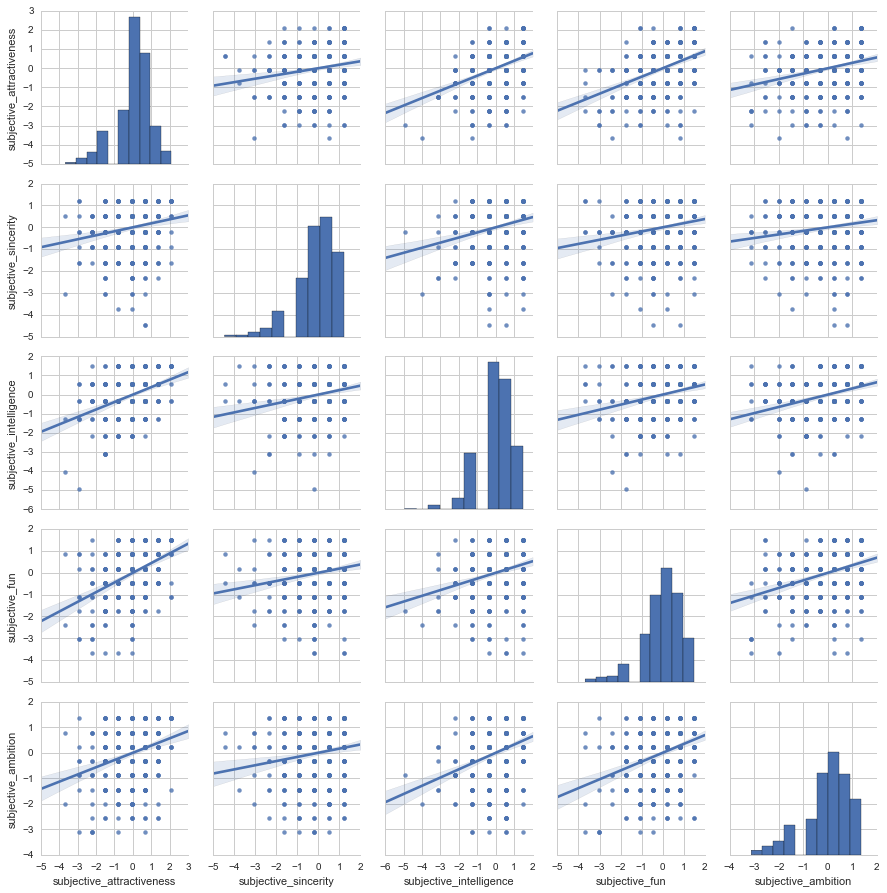

In [8]:
sns.pairplot(subjective, kind = "reg")
plt.show()

In [9]:
sd.columns

Index([u'subject_id', u'wave', u'like_sports', u'like_tvsports',
       u'like_exercise', u'like_food', u'like_museums', u'like_art',
       u'like_hiking', u'like_gaming', u'like_clubbing', u'like_reading',
       u'like_tv', u'like_theater', u'like_movies', u'like_concerts',
       u'like_music', u'like_shopping', u'like_yoga',
       u'subjective_attractiveness', u'subjective_sincerity',
       u'subjective_intelligence', u'subjective_fun', u'subjective_ambition'],
      dtype='object')

In [16]:
like_cols = ['like_tvsports', 'like_sports', 'like_museums', 'like_theater', 'like_shopping']
sd_like = sd[like_cols]

sd_like = (sd_like - sd_like.mean()) / sd_like.std()

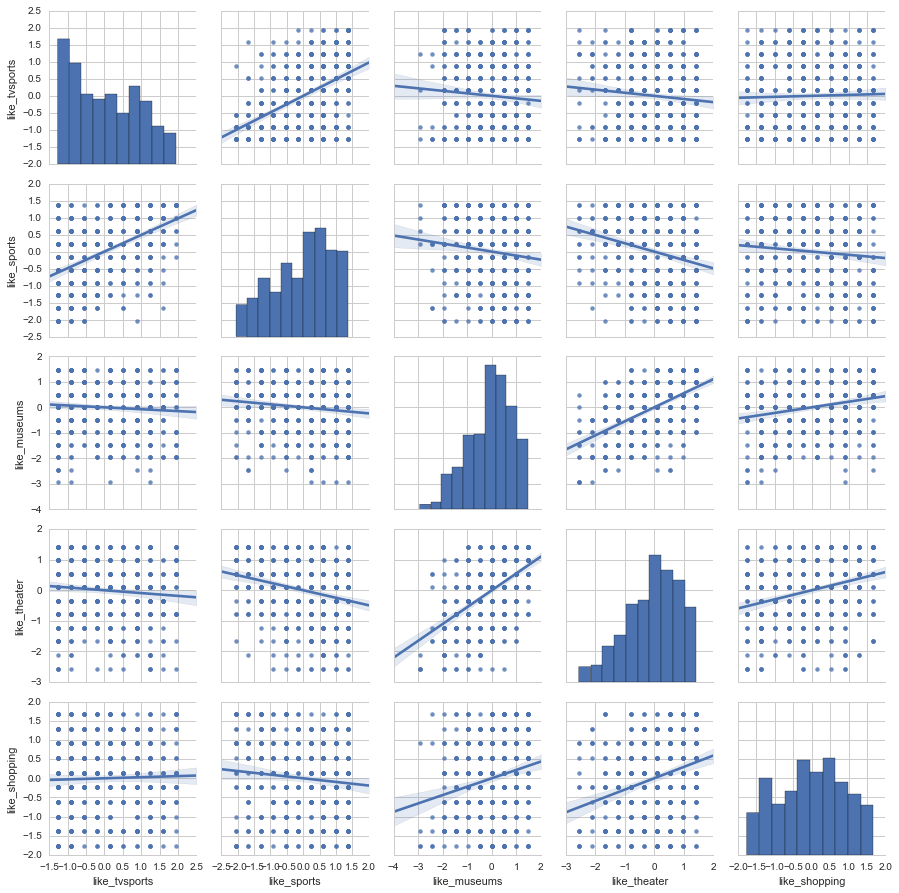

In [17]:
sns.pairplot(sd_like, kind="reg")

## Performing PCA on Subjective Columns

In [18]:
subjective_pca = PCA(n_components=5)
subjective_pca.fit(subjective.values)

PCA(copy=True, n_components=5, whiten=False)

In [19]:
subj_components = subjective_pca.components_

In [22]:
print subjective_cols, '\n'
print '-------------------------------------\n'

for i, pc in enumerate(['PC1', 'PC2', 'PC3', 'PC4', 'PC5']):
    print pc, 'weighing vector:', subj_components[i]
    print '-------------------------------------\n'

['subjective_attractiveness', 'subjective_sincerity', 'subjective_intelligence', 'subjective_fun', 'subjective_ambition'] 

-------------------------------------

PC1 weighing vector: [ 0.50189394  0.31528977  0.46707122  0.48386412  0.44318711]
-------------------------------------

PC2 weighing vector: [-0.21825979  0.90905995  0.09768977 -0.27400972 -0.20334221]
-------------------------------------

PC3 weighing vector: [ 0.40202351  0.14438615 -0.42289342  0.48141404 -0.63791176]
-------------------------------------

PC4 weighing vector: [-0.34811874  0.21377638 -0.64842003  0.36104737  0.53132783]
-------------------------------------

PC5 weighing vector: [-0.64626278 -0.08749096  0.41594928  0.57330577 -0.27017855]
-------------------------------------



In [23]:
subj_exp_var_eigenvals = subjective_pca.explained_variance_
subj_exp_var_pct = subjective_pca.explained_variance_ratio_

print 'eigenvalues:', subj_exp_var_eigenvals, '\n'
print 'explained variance pct', subj_exp_var_pct

# PC1 explains 43% of the way people responded

eigenvalues: [ 2.15245016  0.8859719   0.73548737  0.71963528  0.4972302 ] 

explained variance pct [ 0.43128576  0.17752191  0.14736937  0.14419309  0.09962986]


In [24]:
subj_to_pcs = subjective_pca.transform(subjective.values)

In [25]:
person1_original_ratings = subjective.iloc[0, :]
print person1_original_ratings

subjective_attractiveness   -0.785746
subjective_sincerity        -0.202528
subjective_intelligence     -0.353867
subjective_fun               0.193145
subjective_ambition         -0.323290
Name: 0, dtype: float64


In [27]:
person1_pcas = subj_to_pcs[0,:]
print person1_pcas

[-0.67332    -0.0343678   0.10373029  0.35765309  0.5764042 ]


In [28]:
confidence_weights = subj_components[0]

In [30]:
how_to_make_pc1 = pd.DataFrame({'person1_original': person1_original_ratings.values},
                              index = subjective.columns)
how_to_make_pc1

,person1_original
subjective_attractiveness,-0.785746
subjective_sincerity,-0.202528
subjective_intelligence,-0.353867
subjective_fun,0.193145
subjective_ambition,-0.323290


In [31]:
how_to_make_pc1['weights_to_make_pc1'] = confidence_weights
how_to_make_pc1

,person1_original,weights_to_make_pc1
subjective_attractiveness,-0.785746,0.501894
subjective_sincerity,-0.202528,0.315290
subjective_intelligence,-0.353867,0.467071
subjective_fun,0.193145,0.483864
subjective_ambition,-0.323290,0.443187


In [32]:
# pieces_pf_pc1_value = linear combination of weights multiplied by the original rankings. 
how_to_make_pc1['pieces_of_pc1_value'] = how_to_make_pc1.person1_original * how_to_make_pc1.weights_to_make_pc1
how_to_make_pc1

,person1_original,weights_to_make_pc1,pieces_of_pc1_value
subjective_attractiveness,-0.785746,0.501894,-0.394361
subjective_sincerity,-0.202528,0.315290,-0.063855
subjective_intelligence,-0.353867,0.467071,-0.165281
subjective_fun,0.193145,0.483864,0.093456
subjective_ambition,-0.323290,0.443187,-0.143278


In [33]:
print 'sum of linear combinations of weights * original values for PC1:', np.sum(how_to_make_pc1.pieces_of_pc1_value)
print 'person 1s pca variables:', person1_pcas

sum of linear combinations of weights * original values for PC1: -0.673319996102
person 1s pca variables: [-0.67332    -0.0343678   0.10373029  0.35765309  0.5764042 ]


## Fit PCA to some things people like and attributes

In [34]:
sd.columns

Index([u'subject_id', u'wave', u'like_sports', u'like_tvsports',
       u'like_exercise', u'like_food', u'like_museums', u'like_art',
       u'like_hiking', u'like_gaming', u'like_clubbing', u'like_reading',
       u'like_tv', u'like_theater', u'like_movies', u'like_concerts',
       u'like_music', u'like_shopping', u'like_yoga',
       u'subjective_attractiveness', u'subjective_sincerity',
       u'subjective_intelligence', u'subjective_fun', u'subjective_ambition'],
      dtype='object')

In [35]:
personas = ['like_tvsports', 'like_art', 'like_shopping', 'subjective_attractiveness', 
           'subjective_intelligence', 'subjective_fun']
sd_personas = sd[personas]

sd_personas = (sd_personas - sd_personas.mean()) / sd_personas.std()

In [36]:
personas_pca = PCA(n_components = 6)
personas_pca.fit(sd_personas)

PCA(copy=True, n_components=6, whiten=False)

In [37]:
personas_comp = personas_pca.components_

In [40]:
print personas_pca.explained_variance_ratio_
print '-------------------------------------\n'

print personas
print '-------------------------------------\n'

for i, pc in enumerate(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']):
    print pc, 'weighing vector:', personas_comp[i]
    print '-------------------------------------\n'

[ 0.31342417  0.19552818  0.17073703  0.12776802  0.10675673  0.08578586]
-------------------------------------

['like_tvsports', 'like_art', 'like_shopping', 'subjective_attractiveness', 'subjective_intelligence', 'subjective_fun']
-------------------------------------

PC1 weighing vector: [ 0.12982675  0.24668847  0.30558838  0.56958347  0.43842908  0.55880244]
-------------------------------------

PC2 weighing vector: [-0.45022908  0.63588766  0.51171618 -0.13404284 -0.33100567 -0.05962356]
-------------------------------------

PC3 weighing vector: [ 0.73472504 -0.09398789  0.45299822 -0.19203299 -0.42997342  0.15615438]
-------------------------------------

PC4 weighing vector: [-0.45301259 -0.72053207  0.44903355  0.16364408 -0.16546649  0.14079579]
-------------------------------------

PC5 weighing vector: [ 0.12439408 -0.07143643  0.48775384 -0.19536483  0.62703961 -0.55693182]
-------------------------------------

PC6 weighing vector: [-0.14115101 -0.04108921 -0.00447033

In [41]:
personas_pcs = personas_pca.transform(sd_personas)

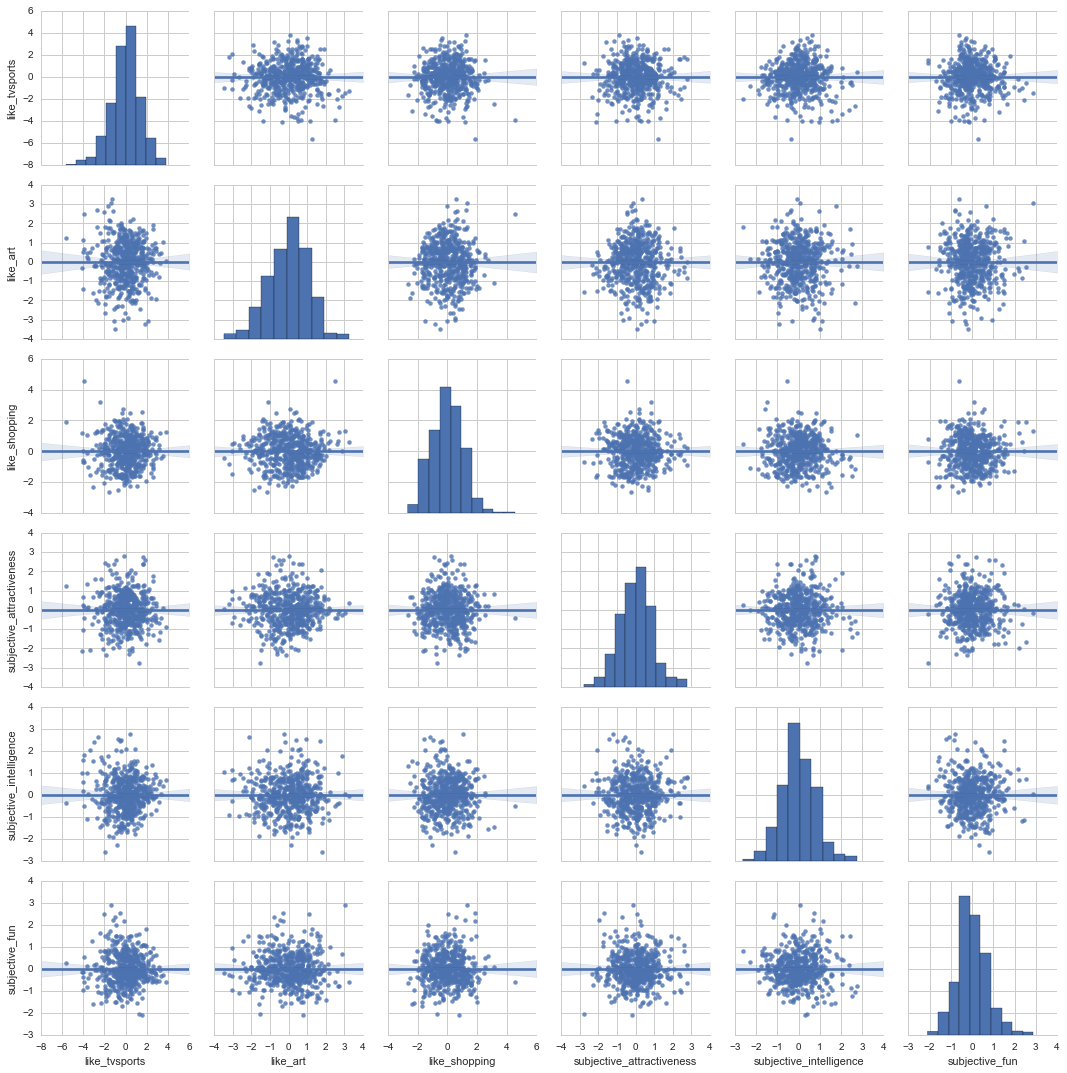

In [43]:
sns.pairplot(pd.DataFrame(personas_pcs, columns=personas), kind="reg")

In [44]:
sd.columns

Index([u'subject_id', u'wave', u'like_sports', u'like_tvsports',
       u'like_exercise', u'like_food', u'like_museums', u'like_art',
       u'like_hiking', u'like_gaming', u'like_clubbing', u'like_reading',
       u'like_tv', u'like_theater', u'like_movies', u'like_concerts',
       u'like_music', u'like_shopping', u'like_yoga',
       u'subjective_attractiveness', u'subjective_sincerity',
       u'subjective_intelligence', u'subjective_fun', u'subjective_ambition'],
      dtype='object')

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
reading = sd['like_reading'].values

In [46]:
original_lr = LinearRegression()
original_scores = cross_val_score(original_lr, sd_personas.values, reading, cv=11)
print personas
print original_scores
print np.mean(original_scores)

['like_tvsports', 'like_art', 'like_shopping', 'subjective_attractiveness', 'subjective_intelligence', 'subjective_fun']
[-0.03929709 -0.00121085  0.18746648 -0.01366106 -0.00631195 -0.09939476
  0.07104435  0.08631772  0.125047    0.15188839  0.06471037]
0.0478725992337


In [47]:
pca_lr = LinearRegression()
pca_scores = cross_val_score(pca_lr, personas_pcs, reading, cv=11)
print pca_scores
print np.mean(pca_scores)

[-0.03929709 -0.00121085  0.18746648 -0.01366106 -0.00631195 -0.09939476
  0.07104435  0.08631772  0.125047    0.15188839  0.06471037]
0.0478725992337


In [48]:
print sd_personas.values[0]
print personas_pcs[0]

[-0.91193749 -2.52436043  0.91241092 -0.78574642 -0.35386715  0.1931445 ]
[-0.95706651 -0.5167937   0.3137596   2.59886927  0.33597378  0.81727991]


In [49]:
print original_lr.fit(sd_personas.values, reading).score(sd_personas.values, reading)
print pca_lr.fit(personas_pcs, reading).score(personas_pcs, reading)

0.113611917051
0.113611917051


In [50]:
from sklearn.pipeline import make_pipeline

In [55]:
# make a pca and a linear regression model
pca = PCA()
lr = LinearRegression()

# make a pipeline that chains together the pca and the linear regression
# this means that when the X data gets "piped in" it first hits the pca,
# which will fit it to the data, then transform the original variables
# into their principal component "new variables"
# From here these principal components get send into the linear regression
# to be fit.

# This is very useful bcause we can actually gridsearch the number of
# components - gridsearch is designed to run on models that return
# some kind of score. The PCA ahs no score, it's just transforming the variables.
# So gridsearching the PCA itself is not possible/meaningless. 
# However, if it then goes to a linear regression after, we can score it
# on some dependent variable in order to determine which number of components
# was the the best one!
pca_pipe = make_pipeline(pca, lr)

pca_grid = {
    'pca__n_components':[1, 2, 3, 4, 5, 6]
}

from sklearn.grid_search import GridSearchCV

# Gridsearch now takes the pipeline:
pca_gs = GridSearchCV(pca_pipe, pca_grid, cv=11)

# fit it on the data X, y as usual
pca_gs.fit(sd_personas.values, reading)

print pca_gs.best_params_
print pca_gs.best_score_

{'pca__n_components': 5}
0.0523966890955
